<a href="https://colab.research.google.com/github/Felhaba/Modelling/blob/main/CreditCalibration_Vol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
from bs4 import BeautifulSoup
from scipy.optimize import fsolve

In [ ]:
path = '!!!!!!!!!!!!!!!!!!!!!!' #fill it in accordingly

### Vol calibration in xVA

* The input data is a series of $n$ credit curves (CDS market quotes) at dates $t_i$, for $i \in [1, n]$;
* We suppose that the recovery rate is known and fixed at $40\%$. Then we do the following classical approximation to get the default spread curves: $\Lambda (t, T) = \dfrac{CR(t, T)}{LGD}$, with $\Lambda (t, T)$ is the default intensity (probablity of default on the hotizon $[t, T]$) at date $t$ for the horizon $T$, and $LGD$ is the Loss Given Default such as: $LGD = 1 - RR$.

In [ ]:
df_egypt = pd.read_csv(f'{path}EGYPT_N-13788976.csv', sep = ',') # pd.read_excel(f'{path}USD.csv', 'USD')

In [ ]:
df_egypt

,dates,0.5,1,2,3,4,5,7,10
0,5/17/2021,0.021679,0.024348,0.029896,0.037185,0.041819,0.046223,0.050225,0.053695
1,5/18/2021,0.022205,0.025018,0.030231,0.037509,0.042231,0.046627,0.050496,0.054044
2,5/19/2021,0.022304,0.025114,0.030461,0.037930,0.042682,0.047107,0.051054,0.054711
3,5/20/2021,0.020562,0.023967,0.029658,0.037337,0.042028,0.046466,0.050887,0.054267
4,5/21/2021,0.021269,0.024305,0.029829,0.037431,0.042116,0.046532,0.050851,0.054374
...,...,...,...,...,...,...,...,...,...
949,1/7/2025,0.045020,0.046579,0.053016,0.061827,0.071395,0.077903,0.084277,0.088053
950,1/8/2025,0.047660,0.048681,0.054685,0.063090,0.072975,0.079817,0.085776,0.089763
951,1/9/2025,0.043333,0.047203,0.053908,0.062037,0.071714,0.078667,0.085013,0.089279
952,1/10/2025,0.047094,0.049072,0.055290,0.063169,0.073067,0.080133,0.086104,0.090041


In [ ]:
n_obs = df_egypt.shape[0] + 1

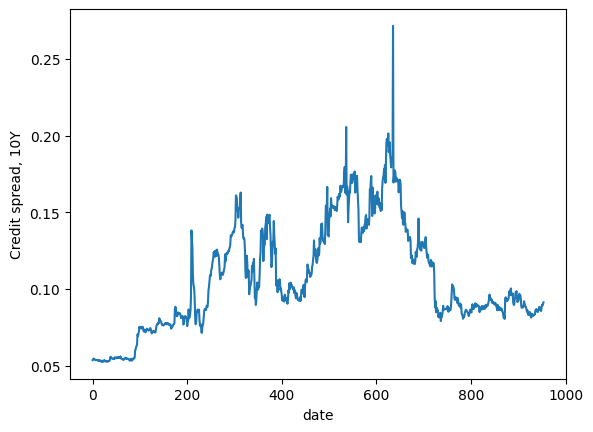

In [ ]:
y_r = df_egypt['10']

# plotting the points
plt.plot(y_r)
#labelling the axis
plt.xlabel("date")
plt.ylabel("Credit spread, 10Y")
# function to show the plot
plt.show()

It is possible to weight the observations, in order to give more importance to the recent ones over the older ones. The system uses an exponential weighting scheme with a parameter $\lambda \in [0,1]$. Suppose that we have $n$ observations of two processes $X$ and $Y$ for $i\in[1,n]$ ($1$ being the most recent date and $n$ the oldest), we note $x_i$ and $y_i$ for the obervations of the process $X$ and $Y$ respectively at time $t_i$.

We define the following weights $w_i$ depending of the parameter $\lambda \in [0,1]$:

$$w_i = \frac{\lambda^{t_i - t_n}}{\sum_{i=1}^{n}\lambda^{t_i - t_n}}$$

\* also simple **min-max** or **Zero Mean** normalisation passes.

In [ ]:
df_w = pd.DataFrame()
df_w['weights'] = [x/(n_obs*1.1) for x in range(1, n_obs)]
df_w['dates'] = df_egypt['dates']

In [ ]:
df_w

,weights,dates
0,0.000952,5/17/2021
1,0.001904,5/18/2021
2,0.002856,5/19/2021
3,0.003808,5/20/2021
4,0.004760,5/21/2021
...,...,...
949,0.904331,1/7/2025
950,0.905283,1/8/2025
951,0.906235,1/9/2025
952,0.907187,1/10/2025


In [ ]:
for i in df_egypt.columns[1::]:
  df_egypt[i] = df_egypt[i] * df_w['weights'] #df_egypt[i] / (df_egypt[i].max() - df_egypt[i].min())

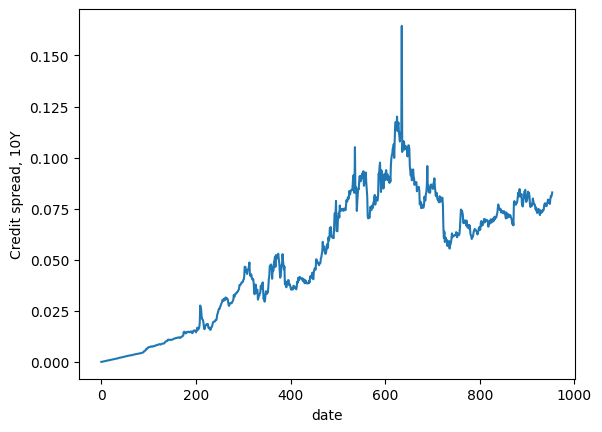

In [ ]:
y_r = df_egypt['10']

# plotting the points
plt.plot(y_r)
#labelling the axis
plt.xlabel("date")
plt.ylabel("Credit spread, 10Y")
# function to show the plot
plt.show()

In [ ]:
#store the number of columns (will be used in computing delta)
n_col = len(df_egypt.columns)

In [ ]:
df_egypt['dates'] = pd.to_datetime(df_egypt['dates'], format='%m/%d/%Y')

In [ ]:
df_egypt['Delta'] = df_egypt['dates'].diff().dt.days #days difference

In [ ]:
#coumpute default intensity
df_egypt[df_egypt.columns[1::]] = df_egypt[df_egypt.columns[1::]].div(0.6)

For variance estimation the folowing process is considered:
$$D_i^{CIR}(\tau) = \dfrac{\Lambda_{i+1} (t, T) - \Lambda_{i} (t, T)}{\sqrt{\lambda_i}}$$
with instantaneous  default intensity observations $(\lambda_i)_{1 \leq i \leq n}$.

This delta can be seen as normalized change in default intensity/probablity of default for a given time horizon.

In [ ]:
#D_i CIR by pillar
df_egypt_di = pd.DataFrame()

for i in df_egypt.columns[1:n_col]:
  name = 'Di_' + i
  df_egypt_di[name] = df_egypt[i].diff()/np.sqrt(df_egypt[i].shift(1))

df_egypt_di.head(2)

,Di_0.5,Di_1,Di_2,Di_3,Di_4,Di_5,Di_7,Di_10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.006149,0.006557,0.007041,0.007815,0.008306,0.008713,0.009023,0.00935


let's define $\tau = T - t$

In [ ]:
#(T-t) by pillar
for i in df_egypt.columns[1:n_col]:
  name = '(T-t)' + i
  df_egypt[name] = float(i) - df_egypt['Delta']/365

df_egypt.head(3)

,dates,0.5,1,2,3,4,5,7,10,Delta,(T-t)0.5,(T-t)1,(T-t)2,(T-t)3,(T-t)4,(T-t)5,(T-t)7,(T-t)10
0,2021-05-17,0.000034,0.000039,0.000047,0.000059,0.000066,0.000073,0.000080,0.000085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-18,0.000070,0.000079,0.000096,0.000119,0.000134,0.000148,0.000160,0.000171,1.666667,0.495434,0.995434,1.995434,2.995434,3.995434,4.995434,6.995434,9.995434
2,2021-05-19,0.000106,0.000120,0.000145,0.000181,0.000203,0.000224,0.000243,0.000260,1.666667,0.495434,0.995434,1.995434,2.995434,3.995434,4.995434,6.995434,9.995434


In [ ]:
cnt = df_egypt.shape[0] #count the number of rows
days_diff = (df_egypt['dates'].iloc[-1] - df_egypt['dates'].iloc[0]).days #number of days in the df
Delta = days_diff/(365*(cnt-1))
a = 0.03 #externally defined
Tau = df_egypt.columns[1:n_col] #list of pillars

New issues appear with this inversion method because the inverted values of $\lambda_i$ may not be always positive. Moreover very small values of
$\lambda_i$ should increase the statistical variance to abnormal values. To prevent these issues to happen, we use the following solution:
* we compute a weighted variance and we do not take into account index of date
$t_i$ if the inverted $\lambda_i$ is below a given threshold.
* when the values of $\lambda_i$ exceeds the threshold, we apply a penalization weight for the index $i$ based on the difference between $\lambda_i$ and the threshold.
More precisely the penalization weight $w$ is a function of $\lambda_{inverted}$:

In [ ]:
df_egypt_weight = df_egypt.iloc[::, 1:n_col]
df_egypt_weight['0.5'].min()

3.439513564969062e-05

In [ ]:
#compute historical std
std_stat = list(df_egypt_di.std(axis = 0))

Least Square Minimization or L2-Norm. The min function is $\sum\limits_{j=1}^p (\sqrt{Var_{stat}[D_{CIR}](\tau_j)} - \sqrt{Var_{CIR}[D_{CIR}](\tau_j)})^2$, With $Var_{CIR}$ being the theoretical variance, and $Var_{stat}$ stands for
statistical variance.

$Var_{CIR} \left[ D^{CIR} (\tau) \right]= \frac{\Delta}{\tau^2}\left( \sigma B^{CIR}(\tau) \right)^2$ - from this equation we are looking for a standartized $\sigma$ that can be seen as a risk-neutral volatility implied form the credit market data. This value is seen in GUI's CVA Historical Calibration menu.



In [ ]:
# Define the function (Var_CIR = f(sigma))
def root(x):
  std_Di = []
  for t in Tau:
    tau = float(t)
    h = (a**2+2*x**2)**0.5
    B = 2*np.exp(tau*h)/(2*h+(a+h)*np.exp(tau*h)-1)
    var_Di = Delta * (B*x/tau)**2
    std_Di.append(var_Di**0.5)
  # sum_diff = sum(np.square(np.array(std_Di) - np.array(std_stat)))
  # print(sum_diff)
  return std_Di

In [ ]:
# std_stat

In [ ]:
b = 0.001 #a risk-neutral volatility implied form the credit market data. This value is seen in GUI's CVA Historical Calibration menu
while abs(sum(np.square(np.array(root(b)) - np.array(std_stat)))) > 0.01:
  b += 0.001
print(b) #root(b)

0.001


In [ ]:
abs(sum(np.square(np.array(root(b)) - np.array(std_stat)))) #remaining error

0.0038924676701955047

In [ ]:
#Excel's root
# sum(np.square(np.array(root(0.842026424393183)) - np.array(std_stat)))

In [ ]:
#GUI's root
round(sum(np.square(np.array(root(1)) - np.array(std_stat))), 5)

0.00597

In [ ]:
#Python's root
round(sum(np.square(np.array(root(0.09)) - np.array(std_stat))), 5)

0.00025

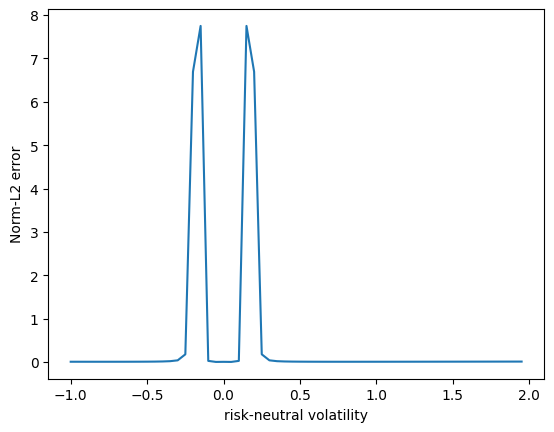

In [ ]:
# setting the x - risk-neutral volatility
x = np.arange(-1, 2, 0.05)
# setting the corresponding y - Norm-L2 error
y = [sum(np.square(np.array(root(i)) - np.array(std_stat))) for i in x]

# plotting the points
plt.plot(x, y)
#labelling the axis
plt.xlabel("risk-neutral volatility")
plt.ylabel("Norm-L2 error")
# function to show the plot
plt.show()

In [ ]:
abs(sum(np.square(np.array(root(0.8)) - np.array(std_stat)))) #remaining error

0.005674109327522795

In [ ]:
abs(sum(np.square(np.array(root(0.1)) - np.array(std_stat)))) #remaining error

0.025653267935900743